In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [2]:
data = pd.read_csv("/content/Titanic-Dataset.csv")

In [3]:
quantitative_cols = data.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = data.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

imputer_quantitative = SimpleImputer(strategy="mean")
data[quantitative_cols] = imputer_quantitative.fit_transform(data[quantitative_cols])

imputer_categorical = SimpleImputer(strategy="most_frequent")
data[categorical_cols] = imputer_categorical.fit_transform(data[categorical_cols])


In [4]:
# Extract the title from the name
data["Title"] = data["Name"].apply(lambda x: re.search(' ([A-Za-z]+)\.', x).group(1))

# Classification of rare titles
title_map = data["Title"].value_counts().to_dict()
data["Title"] = data["Title"].map(lambda x: x if title_map[x] > 10 else "Rare")

# Title encoding
data["Title"] = LabelEncoder().fit_transform(data["Title"])

# Create family size
data["FamilySize"] = data["SibSp"] + data["Parch"] + 1


In [5]:
for col in categorical_cols:
    data[col] = LabelEncoder().fit_transform(data[col])


In [6]:
data.drop(["PassengerId", "Parch", "Age", "SibSp", "Name", "Ticket"], axis=1, inplace=True)


In [7]:
def cap_outliers(series, q1=0.25, q3=0.75):
    IQR = series.quantile(q3) - series.quantile(q1)
    lower = series.quantile(q1) - 1.5 * IQR
    upper = series.quantile(q3) + 1.5 * IQR
    return series.apply(lambda x: lower if x < lower else upper if x > upper else x)

data["Fare"] = cap_outliers(data["Fare"])
data["Cabin"] = cap_outliers(data["Cabin"])


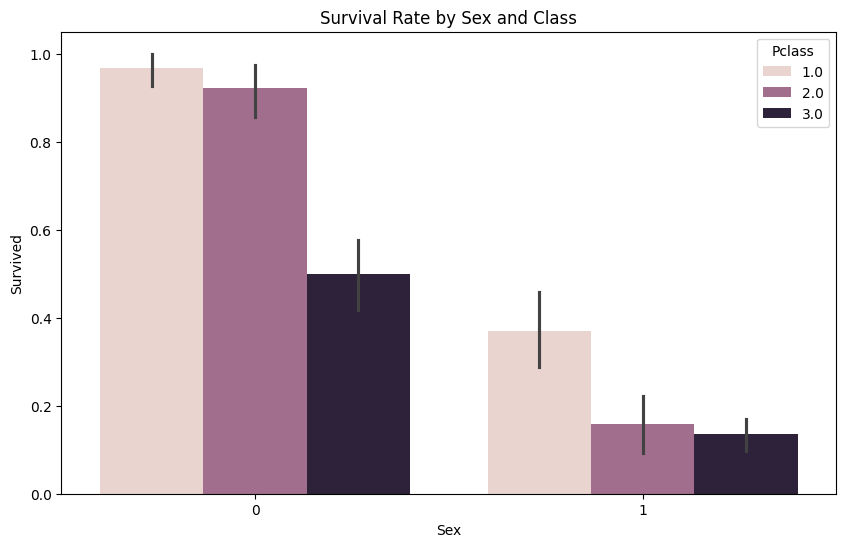

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Sex", y="Survived", hue="Pclass", data=data)
plt.title("Survival Rate by Sex and Class")
plt.show()

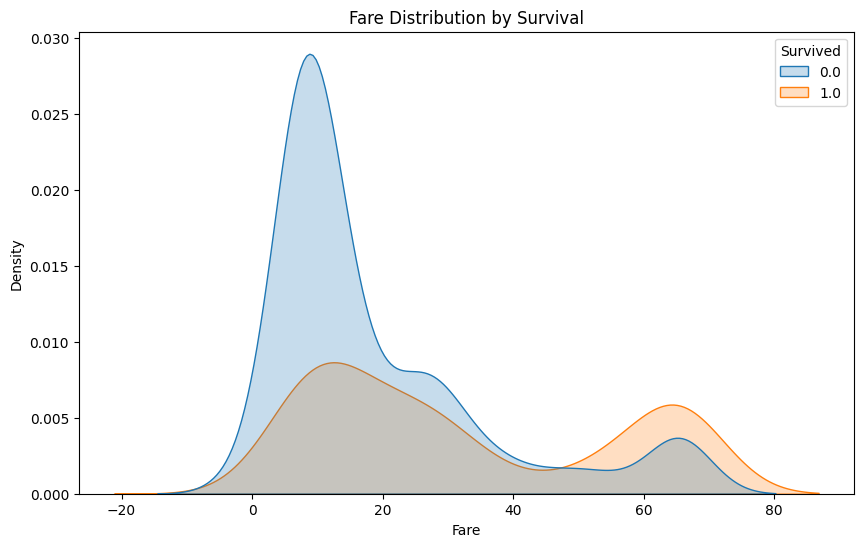

In [9]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x="Fare", hue="Survived", fill=True)
plt.title("Fare Distribution by Survival")
plt.show()

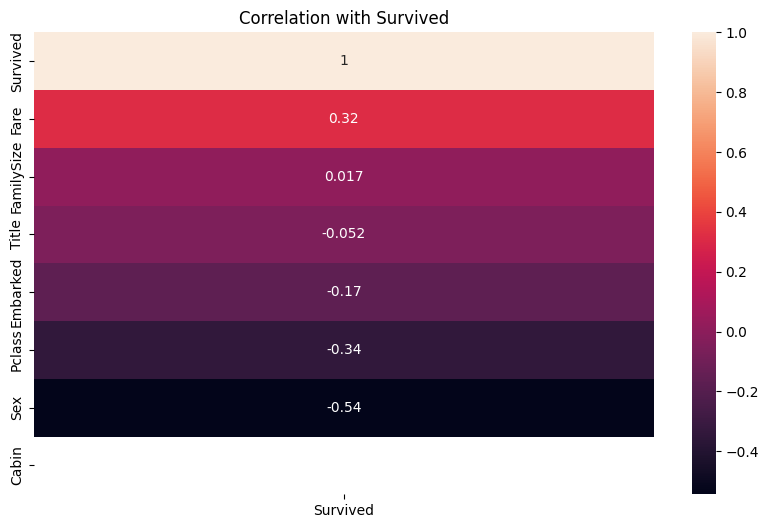

In [11]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr()[["Survived"]].sort_values(by="Survived", ascending=False), annot=True)
plt.title("Correlation with Survived")
plt.show()

In [12]:
features = data.drop("Survived", axis=1)
labels = data["Survived"]

feature_train, feature_test, label_train, label_test = train_test_split(
    features, labels, test_size=0.1, random_state=42, shuffle=True
)

In [13]:
sm = SMOTE(random_state=42, k_neighbors=3)
feature_train_sm, label_train_sm = sm.fit_resample(feature_train, label_train)


In [14]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(feature_train_sm, label_train_sm)
label_pred_rf = rf.predict(feature_test)


In [15]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb.fit(feature_train_sm, label_train_sm)
label_pred_xgb = xgb.predict(feature_test)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:58:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [17]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n Model: {model_name}")
    print(" Accuracy:", round(accuracy_score(y_true, y_pred) * 100, 2), "%")
    print(" Classification Report:\n", classification_report(y_true, y_pred))
    print(" Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

evaluate_model(label_test, label_pred_rf, "Random Forest")
evaluate_model(label_test, label_pred_xgb, "XGBoost")



 Model: Random Forest
 Accuracy: 80.0 %
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.76      0.82        54
         1.0       0.70      0.86      0.78        36

    accuracy                           0.80        90
   macro avg       0.80      0.81      0.80        90
weighted avg       0.82      0.80      0.80        90

 Confusion Matrix:
 [[41 13]
 [ 5 31]]

 Model: XGBoost
 Accuracy: 81.11 %
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.78      0.83        54
         1.0       0.72      0.86      0.78        36

    accuracy                           0.81        90
   macro avg       0.81      0.82      0.81        90
weighted avg       0.82      0.81      0.81        90

 Confusion Matrix:
 [[42 12]
 [ 5 31]]


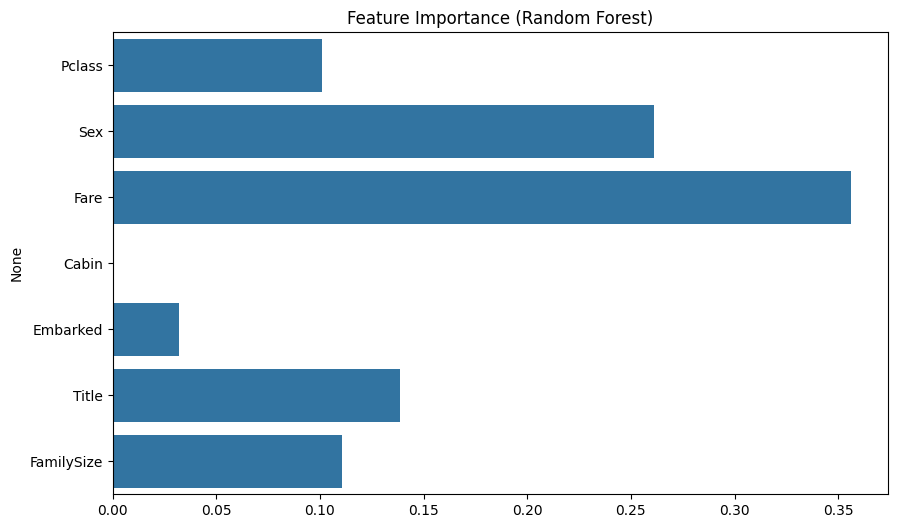

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x=rf.feature_importances_, y=features.columns)
plt.title("Feature Importance (Random Forest)")
plt.show()

In [21]:
from sklearn.model_selection import GridSearchCV

# Improve Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy')
grid_rf.fit(feature_train_sm, label_train_sm)
best_rf = grid_rf.best_estimator_

# Improve XGBoost
param_grid_xgb = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

grid_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
                        param_grid_xgb, cv=3, scoring='accuracy')
grid_xgb.fit(feature_train_sm, label_train_sm)
best_xgb = grid_xgb.best_estimator_


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:03:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:03:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:03:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:03:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:03:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

In [25]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

# Logistics training
log_model = LogisticRegression(max_iter=1000)
log_model.fit(feature_train_sm, label_train_sm)

# Create a voting form
voting_model = VotingClassifier(estimators=[
    ('LogReg', log_model),
    ('RF', best_rf),
    ('XGB', best_xgb)
], voting='soft')  #soft = uses voting probability

voting_model.fit(feature_train_sm, label_train_sm)
label_pred_voting = voting_model.predict(feature_test)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:04:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<ipython-input-24-30fecf63b027>:42: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


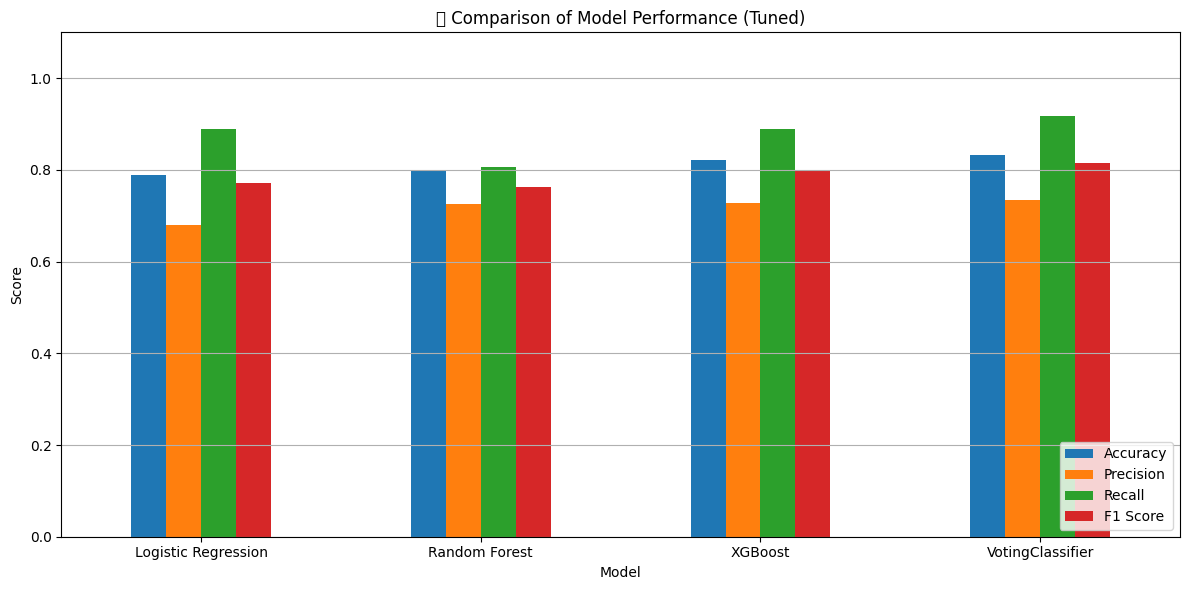

                 Model  Accuracy  Precision  Recall  F1 Score
0  Logistic Regression     0.789      0.681   0.889     0.771
1        Random Forest     0.800      0.725   0.806     0.763
2              XGBoost     0.822      0.727   0.889     0.800
3     VotingClassifier     0.833      0.733   0.917     0.815


In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

models = {
    "Logistic Regression": log_model.predict(feature_test),
    "Random Forest": best_rf.predict(feature_test),
    "XGBoost": best_xgb.predict(feature_test),
    "VotingClassifier": label_pred_voting
}

metrics_data = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

for name, y_pred in models.items():
    acc = accuracy_score(label_test, y_pred)
    prec = precision_score(label_test, y_pred)
    rec = recall_score(label_test, y_pred)
    f1 = f1_score(label_test, y_pred)

    metrics_data["Model"].append(name)
    metrics_data["Accuracy"].append(acc)
    metrics_data["Precision"].append(prec)
    metrics_data["Recall"].append(rec)
    metrics_data["F1 Score"].append(f1)

# Convert results to a table
metrics_df = pd.DataFrame(metrics_data)

# Drawing results
plt.figure(figsize=(12, 6))
metrics_df.set_index("Model").plot(kind="bar", figsize=(12, 6))
plt.title("🔍 Comparison of Model Performance (Tuned)")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Show results
print(metrics_df.round(3))


In [26]:
metrics_df.to_csv("model_comparison_results.csv", index=False)
print(" Results saved to 'model_comparison_results.csv'")


 Results saved to 'model_comparison_results.csv'
